In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.interpolate import interp1d

from plotting_functions import *

ModuleNotFoundError: No module named 'plotting_functions'

In [ ]:
class precip_time_series:
    def __init__(self, data_path):

        self.data,self.statid = self.read_raw_data_as_pandas_df(data_path)
        
        self.padded = False

        self.events = None
        
        self.dimensionless_events = None
        
        self.interpolated_events = None
        
    def read_raw_data_as_pandas_df(self, raw_data_file_path):

        # Read file with timestamp as index
        precip = pd.read_csv(raw_data_file_path, encoding="ISO-8859-1",index_col=1)

        # Timestamps str -> datetime
        precip.index = pd.to_datetime(precip.index)

        # Save ID of station
        station_id = str(precip.station.iloc[0])

        # Remove column with station ID
        precip = precip.drop("station",axis=1) 

        return precip,station_id
    
    def pad_and_resample(self,freq = '5min',pad_value = 0):
        # Resample the data to the specified frequency and pad missing values with pad_value
        self.data = self.data.resample(freq).sum().fillna(pad_value)
        self.padded = True

    def get_events(self,threshold='11h',min_duration = 30, min_precip = 1):
        
        if not self.padded:
            self.pad_and_resample()

        self.init_events(threshold)
        self.filter_events_by_length(min_duration)
        self.filter_events_by_amount(min_precip)

    def init_events(self,threshold):
        
        precip = self.data
        
        # Size of timesteps
        time_delta = precip.index[1]-precip.index[0]

        # Rolling 11 hour sum
        precip_sum = precip.rolling(threshold).sum()

        # dates with no precip last 11 hours
        dates_w_zero_sum = precip_sum.index[(precip_sum.mask(precip_sum!=0)==precip_sum).values[:,0]]

        # Add first date with rain
        for date in precip.index:
            if precip.loc[date].values[0] != 0:
                start_dates = [date]
                break

        # Save start and end dates
        end_dates   = []
        for date in tqdm(dates_w_zero_sum):
            if precip_sum.loc[date- time_delta].values[0]!=0:
                end_dates += [date- pd.to_timedelta(threshold)]
            if precip_sum.loc[date+ time_delta].values[0]!=0:
                start_dates += [date+ time_delta]
        
        # Add end to last event
        for date in reversed(precip.index):  # Iterate from last to first
            if precip.loc[date].values[0] != 0:  # Check if value is not zero
                end_dates += [date]
                break  # Stop at the first nonzero value
        
        # Save events as list of tuples
        events = []
        for i in range(len(end_dates)):
            events+=[(start_dates[i],end_dates[i])]

        # update events
        self.events = events


    def filter_events_by_length(self,min_duration):
        
        # Remove events with duration under min duration
        filtered_events = [event for event in self.events if event[1]-event[0]>=pd.Timedelta(minutes=min_duration)]

        # Update events
        self.events = filtered_events      
        
    def filter_events_by_amount(self,min_precip):
        
        # Remove events with total precip under minimum
        filtered_events = [event for event in self.events if self.data.loc[event[0]:event[1]].sum().values[0]>=min_precip]
        
        # update events
        self.events = filtered_events       
        
    def create_dimensionless_events(self):

        # Make sure events have been computed
        if self.events == None:
            self.get_events()
        
        # Make list of nparrays containing the values of the dimensionless curve
        dimensionless_curves = [self.get_dimensionless_curve(self.data.loc[event[0]:event[1]].values) for event in self.events]

        # Assign to global value
        self.dimensionless_events = dimensionless_curves
 
    def create_interpolated_events(self):
        n=5
        # Make sure events have been computed
        if self.dimensionless_events == None:
            self.create_dimensionless_events()
        
        # Make list of nparrays containing the values of the dimensionless curve
        interpolated_events = [self.get_interpolated_event(event, n) for event in self.dimensionless_events]

        # Assign to global value
        self.interpolated_events = interpolated_events
 

    def create_split_events(self):
        n=5
            
        # Make sure events have been computed
        if self.dimensionless_events == None:
            self.create_dimensionless_events()
        
        # Make list of nparrays containing the values of the dimensionless curve
        split_events = [self.get_split_event(event, n) for event in self.dimensionless_events]

        # Assign to global value
        self.interpolated_events = split_events


    def get_dimensionless_curve(self,series):
    
        # Calculate cumulative rainfall
        cumulative_rainfall = np.cumsum(series)
        cumulative_rainfall = np.append([0],cumulative_rainfall)

        # normalize
        normalized_cumulative_rainfall = cumulative_rainfall/cumulative_rainfall[-1]

        return normalized_cumulative_rainfall

    
    def get_interpolated_event(self, series, n):
        # Calculate cumulative rainfall
        normalized_cumulative_rainfall = series

        # Define target points for bin_number bins
        target_points = np.linspace(0, 1, n+1)

        # Create interpolation function based on existing data points
        rainfall_times = np.array(range(0, len(normalized_cumulative_rainfall)))

        # Normalize time from 0 to 1
        normalized_time = (rainfall_times - rainfall_times[0]) / (rainfall_times[-1] - rainfall_times[0])
        interpolation_func = interp1d(normalized_time, normalized_cumulative_rainfall, kind='linear', fill_value="extrapolate")

        # Interpolate values at target points
        interpolated_values = interpolation_func(target_points)
    
        return interpolated_values    

        
        
    def return_specific_event(self,event_idx):

        # Size of timesteps
        time_delta = self.data.index[1] - self.data.index[0]
        time_delta_minutes = time_delta.seconds / 60

        # Extract event data
        event = self.data.loc[self.events[event_idx][0]:self.events[event_idx][1]]

        return event            
    
    def return_specific_dimensionless_event(self,event_idx):

        # Size of timesteps
        time_delta = self.data.index[1] - self.data.index[0]
        time_delta_minutes = time_delta.seconds / 60
        
        # Extract event data
        event = self.dimensionless_events[event_idx]

        return event       
    
    def return_specific_interpolated_event(self,event_idx):
        
        # Extract event data
        event = self.interpolated_events[event_idx]

        return event     
    
    def return_specific_split_event(self,event_idx):
        
        # Extract event data
        event = self.split_events[event_idx]

        return event      

In [2]:
# Path to data file
raw_data_file = "../Raw_data/minutdata_st535520_2024.xlsx"

# Load the full time series from one rain gauge
ts = precip_time_series(raw_data_file)
 
# Pad and resample to 5minutes
ts.pad_and_resample('5min')

# Split the time series into events
ts.get_events()

# Get dimensionless versions of events
ts.create_dimensionless_events()

# Get interpolated versions of events
ts.create_interpolated_events()

NameError: name 'precip_time_series' is not defined

In [7]:
ts.events[1]

NameError: name 'ts' is not defined

In [151]:
## Get examples for one event
event_idx  = 1
event = ts.return_specific_event(event_idx)
dimensionless_cumulative_event =  ts.return_specific_dimensionless_event(event_idx)
interpolated_dimensionless_cumulative_event =  ts.return_specific_interpolated_event(event_idx)

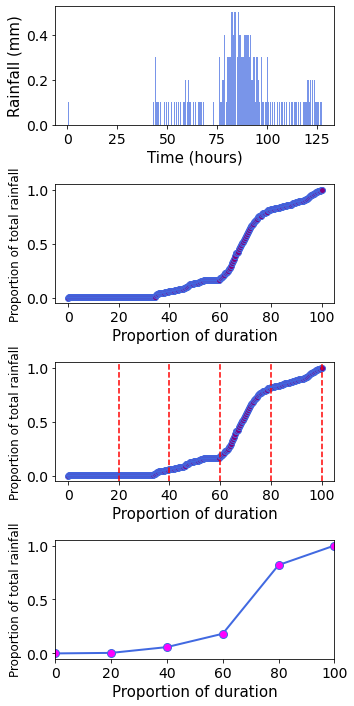

In [157]:
fig, axs = plt.subplots(4, 1, figsize=(5, 12))  
plt.subplots_adjust(hspace=0.5)

# # Generate the various processed data.
# cumulative_rainfall, cumulative_rainfall_times = create_cumulative_event(sample1)
# dimensionless_cumulative_rainfall, dimensionless_times = create_dimensionless_event(cumulative_rainfall, cumulative_rainfall_times)
# interpolated_n_cumulative_rainfall, interpolated_n_times = interpolate_rainfall(dimensionless_cumulative_rainfall, n)
# interpolated_n_incremental_rainfall = create_incremental_event(interpolated_n_cumulative_rainfall)

# Plot each element in its own axis.
plot_raw_data(event['Nedbør (mm)'].values, axs[0])
plot_dimensionless_cumulative(event['Nedbør (mm)'].values, dimensionless_cumulative_event, axs[1], False)
plot_dimensionless_cumulative(event['Nedbør (mm)'].values, dimensionless_cumulative_event, axs[2], boundaries_boolean =True)
plot_interpolated_cumulative(interpolated_dimensionless_cumulative_event, axs[3])
# plot_incremental_rainfall(interpolated_n_incremental_rainfall, axs[4], labels=labels)

# Adjust tick parameters for all subplots.
for ax in axs:
    ax.tick_params(axis='both', labelsize=14)

In [6]:

# =========================================================
# Funtions
# =========================================================



class rainfall_analysis:
    def __init__(self,ts: precip_time_series):
        self.ts = ts
        self.metrics = {} 
        
        # Prepere ts for analysis
        if not self.ts.padded:
            ts.pad_and_resample()

        if ts.events == None:
            ts.get_events()
        
        if ts.dimensioneless_curves == None:
            ts.create_dimensioneless_curves()


#     def huff_quantile(self,ts):
      
#         sums = self.split_ts_sum(ts,4)

#         quantile = np.argmax(sums)+1

#         return quantile

    def interpolate_rainfall(self, ts, bin_number):
        if rainfall is None or len(ts) < 2:
            return None

        # Define target points for bin_number bins
        target_points = np.linspace(0, 1, bin_number+1)

        # Create interpolation function based on existing data points
        rainfall_times = np.array(range(0, len(ts)))

        # Normalize time from 0 to 1
        normalized_time = (rainfall_times - rainfall_times[0]) / (rainfall_times[-1] - rainfall_times[0])
        interpolation_func = interp1d(normalized_time, ts, kind='linear', fill_value="extrapolate")

        # Interpolate values at target points
        interpolated_values = interpolation_func(target_points)

        return interpolated_values, target_points    


    def get_metrics(self):

        padded_precip = self.ts.data
        events_list = self.ts.events
        
        print(events_list)

        # resolution    
        time_delta = padded_precip.index[1]-padded_precip.index[0]
        time_delta_minuts = time_delta.seconds/60

        #####################################
        # Rainfall metrics
        #####################################

        # huff quantiles
        self.metrics["huff_quantile"] = np.array([[self.huff_quantile(padded_precip[event[0]:event[1]])] for event in events_list])





NameError: name 'precip_time_series' is not defined

In [6]:
# =========================================================
# Input
# =========================================================

# Path to data file
raw_data_file =  "/nfs/a319/gy17m2a/PhD/datadir/DanishRainData/Sample1.csv"

# =========================================================
# Script
# =========================================================

# Load ts
ts = precip_time_series(raw_data_file)

# pad and resample 
ts.pad_and_resample('5min')

# Get filtered events
#ts.get_events()

# Get dimensioneless curves
#ts.create_dimensioneless_curves()

# # Analysis
analysis = rainfall_analysis(ts)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25604/25604 [00:03<00:00, 6801.38it/s]


TypeError: split_ts_sum() missing 2 required positional arguments: 'ts' and 'num'

In [16]:
# ts.dimensioneless_curves[1]

### Compute metrics

In [91]:
analysis.get_metrics()

### See all the metrics

In [92]:
analysis.metrics.keys()

dict_keys(['huff_quantile'])

### See all the values for one metric

In [84]:
analysis.metrics['max_intensity']

array([0.02, 0.1 , 0.04, 0.06, 0.12, 0.08, 0.1 , 0.08, 0.08, 0.18, 0.1 ,
       0.04, 0.04, 0.04, 0.08, 0.04, 0.06, 0.08, 0.1 , 0.1 , 0.1 , 0.06,
       0.06, 0.08, 0.1 , 0.06, 0.08, 0.84, 1.04, 0.2 , 0.14, 0.06, 0.12,
       0.34, 0.1 , 0.1 , 0.08, 0.08, 0.46, 0.28, 0.08, 0.18, 0.2 , 0.1 ,
       0.7 , 0.08, 1.62])

### Bla

In [35]:
event_idx = 7
event = ts.return_specific_event(event_idx)
len(event)

34

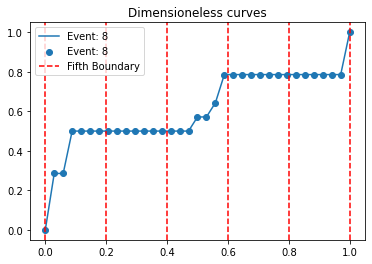

In [38]:
ts.plot_specific_dimensioneless_curve(7)

2025-01-01 00:00:00    1.097627
2025-01-01 00:05:00    1.430379
2025-01-01 00:10:00    1.205527
2025-01-01 00:15:00    1.089766
2025-01-01 00:20:00    0.847310
2025-01-01 00:25:00    1.291788
2025-01-01 00:30:00    0.875174
2025-01-01 00:35:00    1.783546
2025-01-01 00:40:00    1.927326
2025-01-01 00:45:00    0.766883
2025-01-01 00:50:00    1.583450
2025-01-01 00:55:00    1.057790
2025-01-01 01:00:00    1.136089
2025-01-01 01:05:00    1.851193
2025-01-01 01:10:00    0.142072
2025-01-01 01:15:00    0.174259
2025-01-01 01:20:00    0.040437
2025-01-01 01:25:00    1.665240
2025-01-01 01:30:00    1.556314
2025-01-01 01:35:00    1.740024
2025-01-01 01:40:00    1.957237
2025-01-01 01:45:00    1.598317
2025-01-01 01:50:00    0.922959
2025-01-01 01:55:00    1.561058
Freq: 5T, dtype: float64